# Climate Data - Visualization Food for Thought

Cameron Cummins `cameron.cummins@utexas.edu`

Geeta Persad `geeta.persad@jsg.utexas.edu`

In [1]:
import dask.distributed as daskd

cluster = daskd.LocalCluster(n_workers=30, threads_per_worker=2, memory_limit="10GB", dashboard_address=':8001')
client = cluster.get_client()
client

<Client: 'tcp://127.0.0.1:42365' processes=30 threads=60, memory=279.40 GiB>

In [2]:
import pandas as pd
import xarray as xr
import s3fs
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

cesm_ssp370_daily_pr_info = df.query("experiment_id=='ssp370' & table_id=='day' & variable_id=='pr' & source_id=='CESM2'")
cesm_ssp585_daily_pr_info = df.query("experiment_id=='ssp585' & table_id=='day' & variable_id=='pr' & source_id=='CESM2'")
cesm_ssp126_daily_pr_info = df.query("experiment_id=='ssp126' & table_id=='day' & variable_id=='pr' & source_id=='CESM2'")
cesm_hist_daily_pr_info = df.query("experiment_id=='historical' & table_id=='day' & variable_id=='pr' & source_id=='CESM2'")

# We need to drop a few members from the historical data because they have slightly different coordinate data that will cause issues later
cesm_hist_daily_pr_info = cesm_hist_daily_pr_info[cesm_hist_daily_pr_info["member_id"] != 'r4i1p1f1']
cesm_hist_daily_pr_info = cesm_hist_daily_pr_info[cesm_hist_daily_pr_info["member_id"] != 'r11i1p1f1']

def get_concat_dataset(file_interface, s3_paths):
    datasets = []
    ensemble_member_labels = []
    for s3_path in s3_paths:
        ensemble_member_labels.append(s3_path.split("/")[-6])
        mapper = fs.get_mapper(s3_path)
        datasets.append(xr.open_zarr(mapper, consolidated=True))

    return xr.concat(datasets, dim="member").assign_coords(dict(member=ensemble_member_labels))

fs = s3fs.S3FileSystem(anon=True)

cesm_ssp370_daily_pr = get_concat_dataset(fs, cesm_ssp370_daily_pr_info["zstore"])
cesm_ssp585_daily_pr = get_concat_dataset(fs, cesm_ssp585_daily_pr_info["zstore"])
cesm_ssp126_daily_pr = get_concat_dataset(fs, cesm_ssp126_daily_pr_info["zstore"])
cesm_hist_daily_pr = get_concat_dataset(fs, cesm_hist_daily_pr_info["zstore"])

In [3]:
%%time
def get_pr_metrics(pr_ds):
    pr_da = pr_ds["pr"]*86400
    pr_da.attrs["units"] = "mm/day"
    ds = xr.Dataset(
        data_vars=dict(
            max_one_day=pr_da.resample(time="ME").max(),
            max_three_day=pr_da.rolling(time=3, center=False).sum().resample(time="ME").max(),
            max_five_day=pr_da.rolling(time=5, center=False).sum().resample(time="ME").max()
        )
    )
    ds["max_three_day"].attrs["units"] = "mm/3day"
    ds["max_five_day"].attrs["units"] = "mm/5day"
    return ds

cesm_ssp370_monthly_metrics = get_pr_metrics(cesm_ssp370_daily_pr).compute()
cesm_ssp585_monthly_metrics = get_pr_metrics(cesm_ssp585_daily_pr).compute()
cesm_ssp126_monthly_metrics = get_pr_metrics(cesm_ssp126_daily_pr).compute()
cesm_hist_monthly_metrics = get_pr_metrics(cesm_hist_daily_pr).compute()

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 21.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 18s, sys: 36.3 s, total: 2min 54s
Wall time: 7min 17s


In [4]:
start_date = cftime.DatetimeNoLeap(1950, 1, 31, 0, 0, 0, 0, has_year_zero=True)
end_date = cftime.DatetimeNoLeap(2015, 1, 31, 0, 0, 0, 0, has_year_zero=True)
seasonal_means = cesm_hist_monthly_metrics.mean(dim="member").sel(time=slice(start_date, end_date)).groupby('time.season').mean()

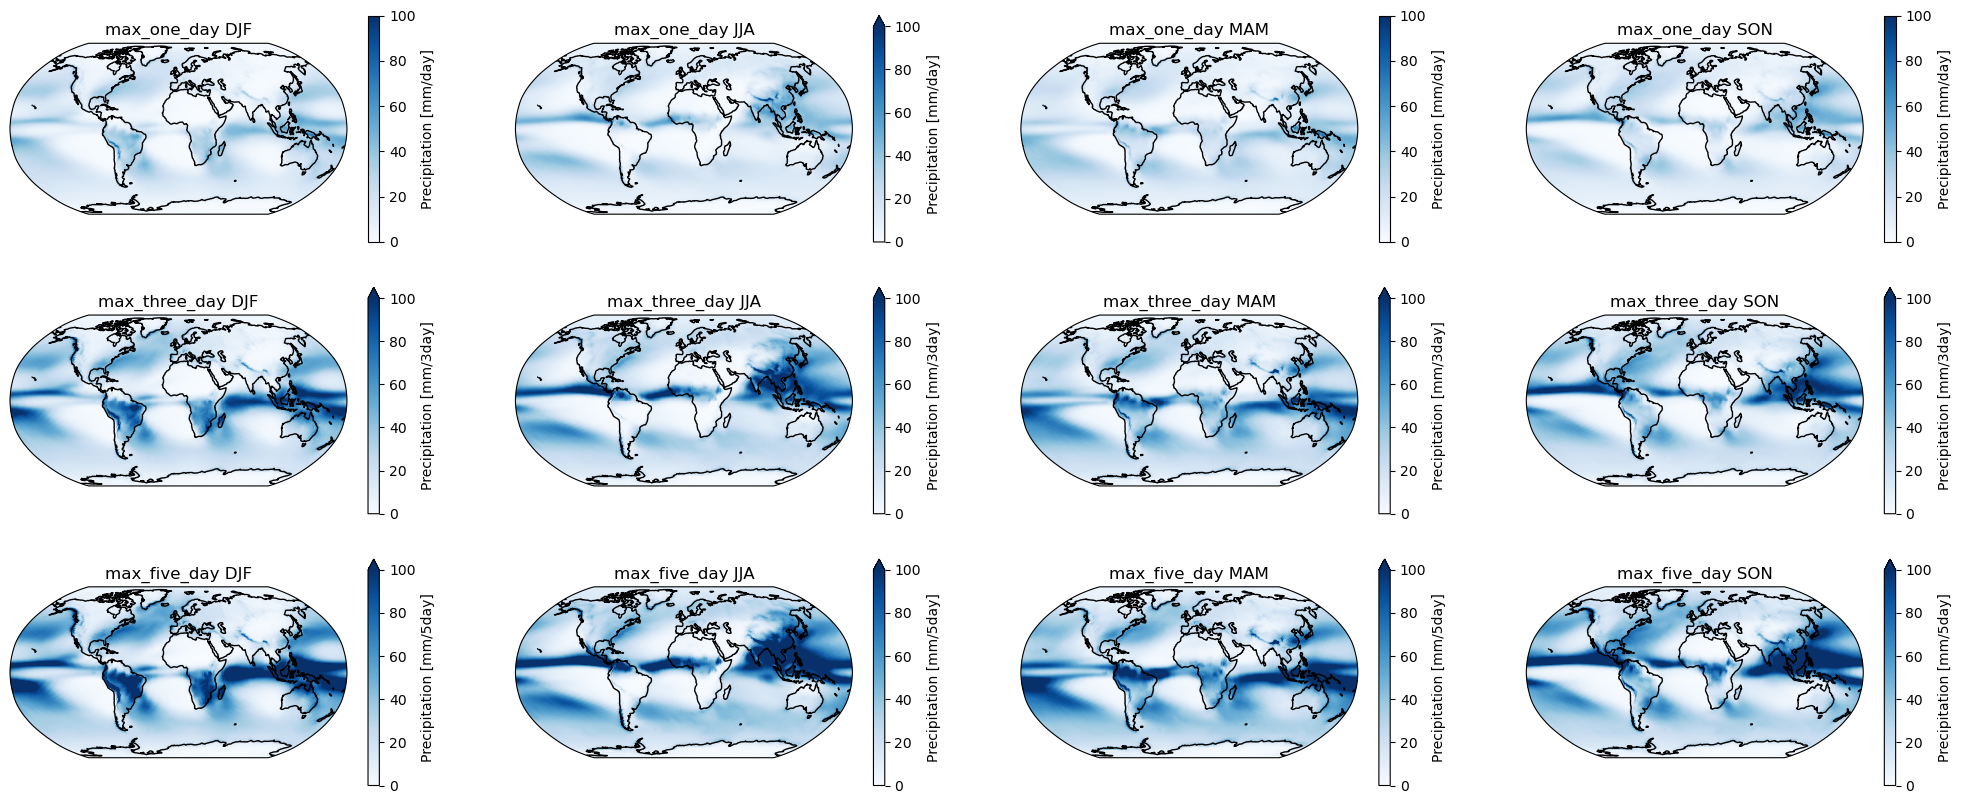

In [5]:
f, axes = plt.subplots(3, 4, figsize=(25, 10), facecolor='w', subplot_kw=dict(projection=ccrs.Robinson()))

for i, variable in enumerate(['max_one_day', 'max_three_day', 'max_five_day']):
    for j, season in enumerate(seasonal_means.season.values):
        seasonal_means[variable].sel(season=season).plot(ax=axes[i, j], transform=ccrs.PlateCarree(), cmap="Blues", vmax=100, vmin=0)
        axes[i, j].coastlines()
        axes[i, j].set_title(f"{variable} {season}")

In [7]:
cesm_hist_monthly_ts = cesm_hist_monthly_metrics.mean(dim=["lat", "lon"])

Text(0.5, 0.98, 'CESM2 Historical Large Ensemble')

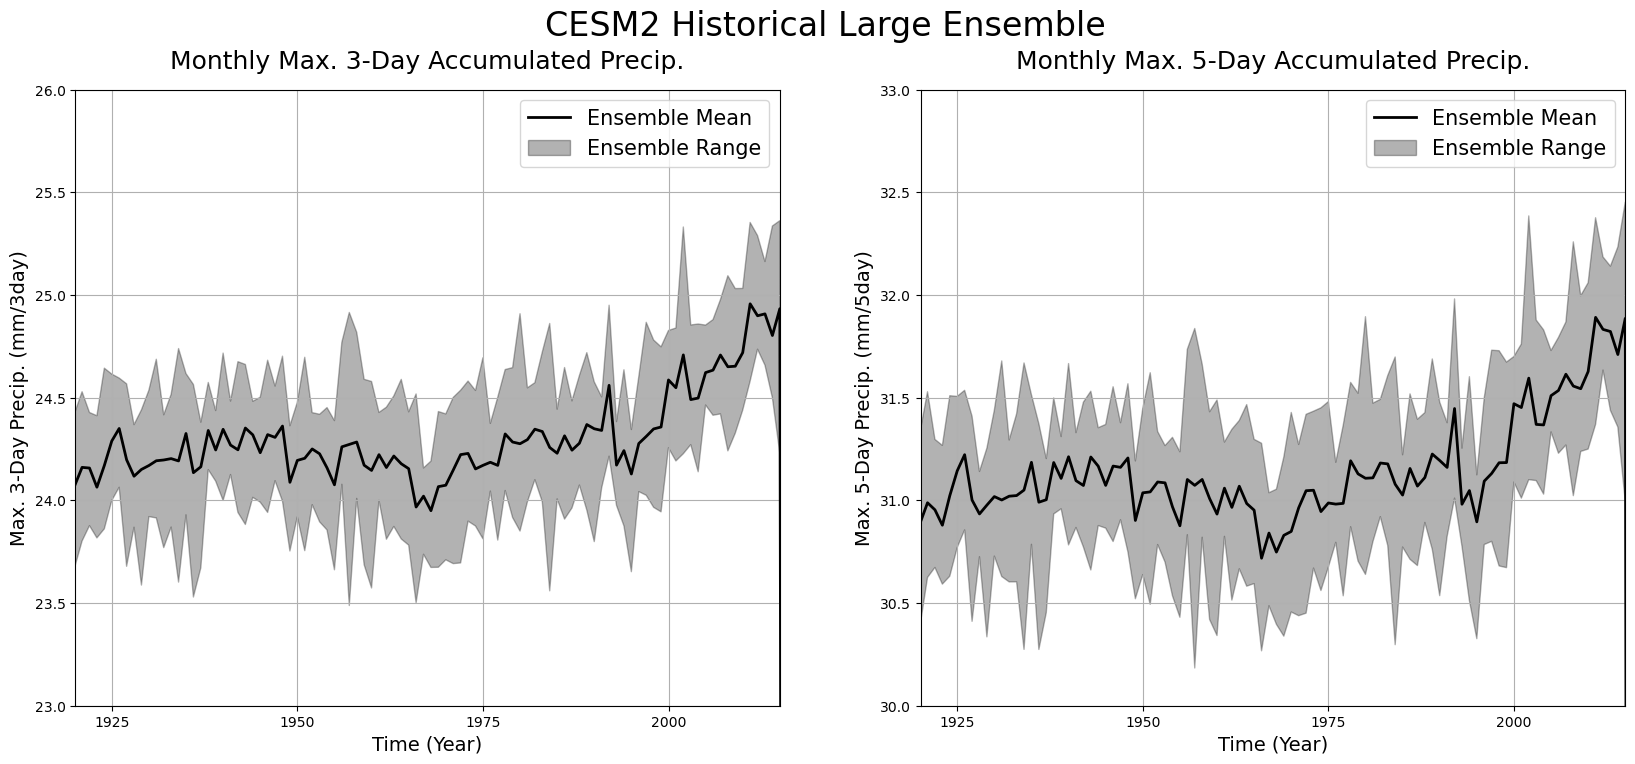

In [42]:
hist_ds = cesm_hist_monthly_ts.resample(time="YE").mean()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

hist_ds["max_three_day"].mean(dim="member").plot(ax=ax1, linewidth=2, color="black", label="Ensemble Mean")
ax1.fill_between(hist_ds.time.values, hist_ds["max_three_day"].min(dim="member"), hist_ds["max_three_day"].max("member"), alpha=0.3, color="black", label="Ensemble Range")
hist_ds["max_five_day"].mean(dim="member").plot(ax=ax2, linewidth=2, color="black", label="Ensemble Mean")
ax2.fill_between(hist_ds.time.values, hist_ds["max_five_day"].min(dim="member"), hist_ds["max_five_day"].max("member"), alpha=0.3, color="black", label="Ensemble Range")


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(
    cftime.DatetimeNoLeap(1920, 1, 31, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True)
)
ax1.set_ylim(23, 26)
ax1.set_title("Monthly Max. 3-Day Accumulated Precip.", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Max. 3-Day Precip. (mm/3day)", fontsize=14)

ax2.grid(zorder=-10)
ax2.legend(fontsize=15)
ax2.set_xlim(
    cftime.DatetimeNoLeap(1920, 1, 31, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True)
)
ax2.set_ylim(30, 33)
ax2.set_title("Monthly Max. 5-Day Accumulated Precip.", fontsize=18, pad=15)
ax2.set_xlabel("Time (Year)", fontsize=14)
ax2.set_ylabel("Max. 5-Day Precip. (mm/5day)", fontsize=14)

f.suptitle("CESM2 Historical Large Ensemble", fontsize=24)

In [43]:
cesm_ssp370_monthly_ts = cesm_ssp370_monthly_metrics.mean(dim=["lat", "lon"])
cesm_ssp585_monthly_ts = cesm_ssp585_monthly_metrics.mean(dim=["lat", "lon"])
cesm_ssp126_monthly_ts = cesm_ssp126_monthly_metrics.mean(dim=["lat", "lon"])

Text(0.5, 0.98, 'CESM2 CMIP6 Large Ensemble')

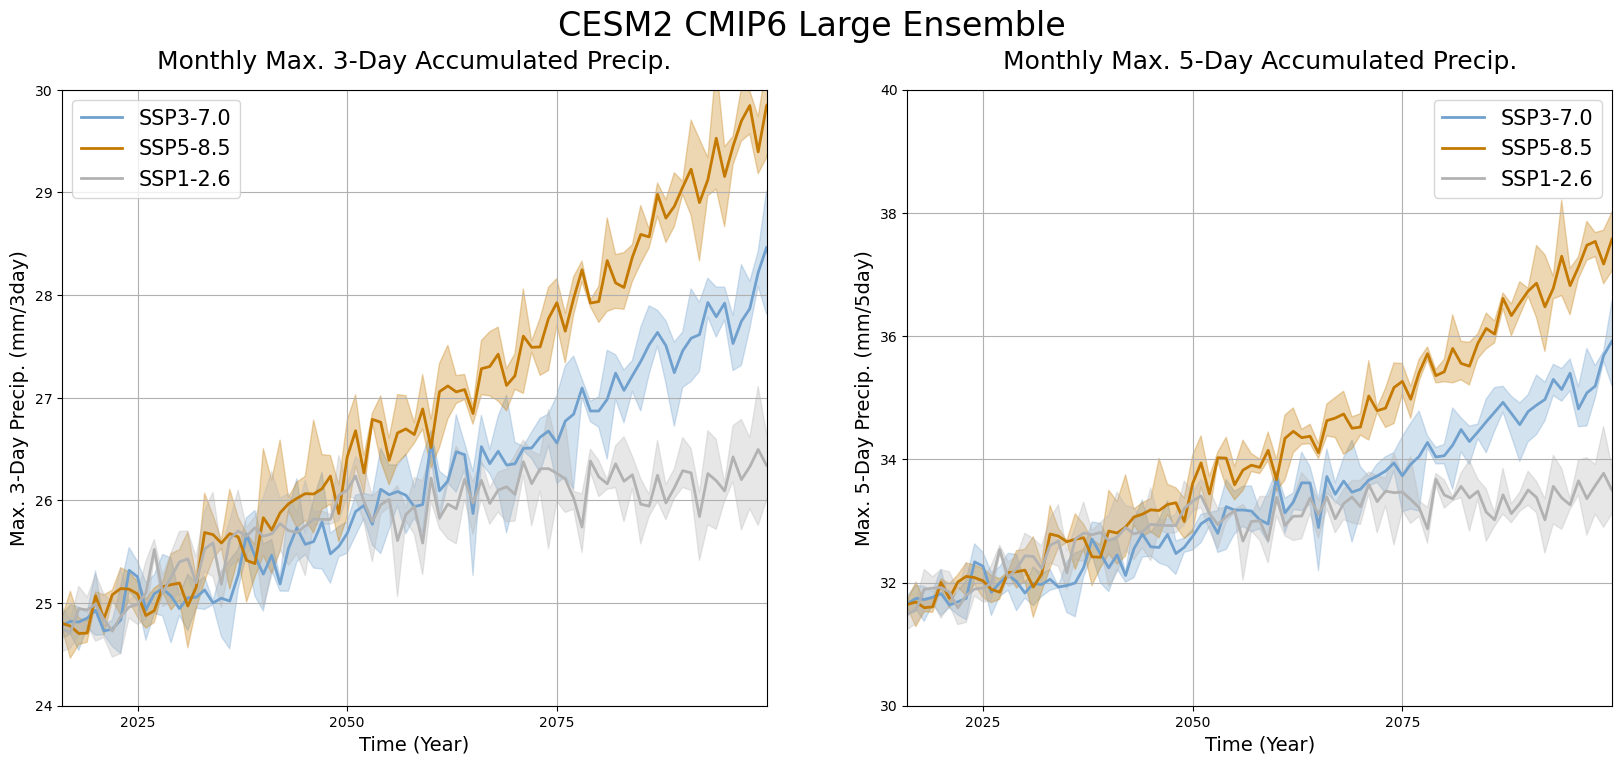

In [76]:
ssp370_ds = cesm_ssp370_monthly_ts.resample(time="YE").mean()
ssp585_ds = cesm_ssp585_monthly_ts.resample(time="YE").mean()
ssp126_ds = cesm_ssp126_monthly_ts.resample(time="YE").mean()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

ssp370_ds["max_three_day"].mean(dim="member").plot(ax=ax1, linewidth=2, color="#70A0CD", label="SSP3-7.0")
ax1.fill_between(ssp370_ds.time.values, ssp370_ds["max_three_day"].min(dim="member"), ssp370_ds["max_three_day"].max("member"), alpha=0.3, color="#70A0CD")

ssp585_ds["max_three_day"].mean(dim="member").plot(ax=ax1, linewidth=2, color="#C47900", label="SSP5-8.5")
ax1.fill_between(ssp585_ds.time.values, ssp585_ds["max_three_day"].min(dim="member"), ssp585_ds["max_three_day"].max("member"), alpha=0.3, color="#C47900")

ssp126_ds["max_three_day"].mean(dim="member").plot(ax=ax1, linewidth=2, color="#B2B2B2", label="SSP1-2.6")
ax1.fill_between(ssp126_ds.time.values, ssp126_ds["max_three_day"].min(dim="member"), ssp126_ds["max_three_day"].max("member"), alpha=0.3, color="#B2B2B2")

ssp370_ds["max_five_day"].mean(dim="member").plot(ax=ax2, linewidth=2, color="#70A0CD", label="SSP3-7.0")
ax2.fill_between(ssp370_ds.time.values, ssp370_ds["max_five_day"].min(dim="member"), ssp370_ds["max_five_day"].max("member"), alpha=0.3, color="#70A0CD")

ssp585_ds["max_five_day"].mean(dim="member").plot(ax=ax2, linewidth=2, color="#C47900", label="SSP5-8.5")
ax2.fill_between(ssp585_ds.time.values, ssp585_ds["max_five_day"].min(dim="member"), ssp585_ds["max_five_day"].max("member"), alpha=0.3, color="#C47900")

ssp126_ds["max_five_day"].mean(dim="member").plot(ax=ax2, linewidth=2, color="#B2B2B2", label="SSP1-2.6")
ax2.fill_between(ssp126_ds.time.values, ssp126_ds["max_five_day"].min(dim="member"), ssp126_ds["max_five_day"].max("member"), alpha=0.3, color="#B2B2B2")

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(
    cftime.DatetimeNoLeap(2015, 12, 31, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(2099, 12, 31, 0, 0, 0, 0, has_year_zero=True)
)
ax1.set_ylim(24, 30)
ax1.set_title("Monthly Max. 3-Day Accumulated Precip.", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Max. 3-Day Precip. (mm/3day)", fontsize=14)

ax2.grid(zorder=-10)
ax2.legend(fontsize=15)
ax2.set_xlim(
    cftime.DatetimeNoLeap(2015, 12, 31, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(2099, 12, 31, 0, 0, 0, 0, has_year_zero=True)
)
ax2.set_ylim(30, 40)
ax2.set_title("Monthly Max. 5-Day Accumulated Precip.", fontsize=18, pad=15)
ax2.set_xlabel("Time (Year)", fontsize=14)
ax2.set_ylabel("Max. 5-Day Precip. (mm/5day)", fontsize=14)

f.suptitle("CESM2 CMIP6 Large Ensemble", fontsize=24)

Text(0.5, 0.98, 'Time-Averaged Monthly Max. 3-Day Precipitation')

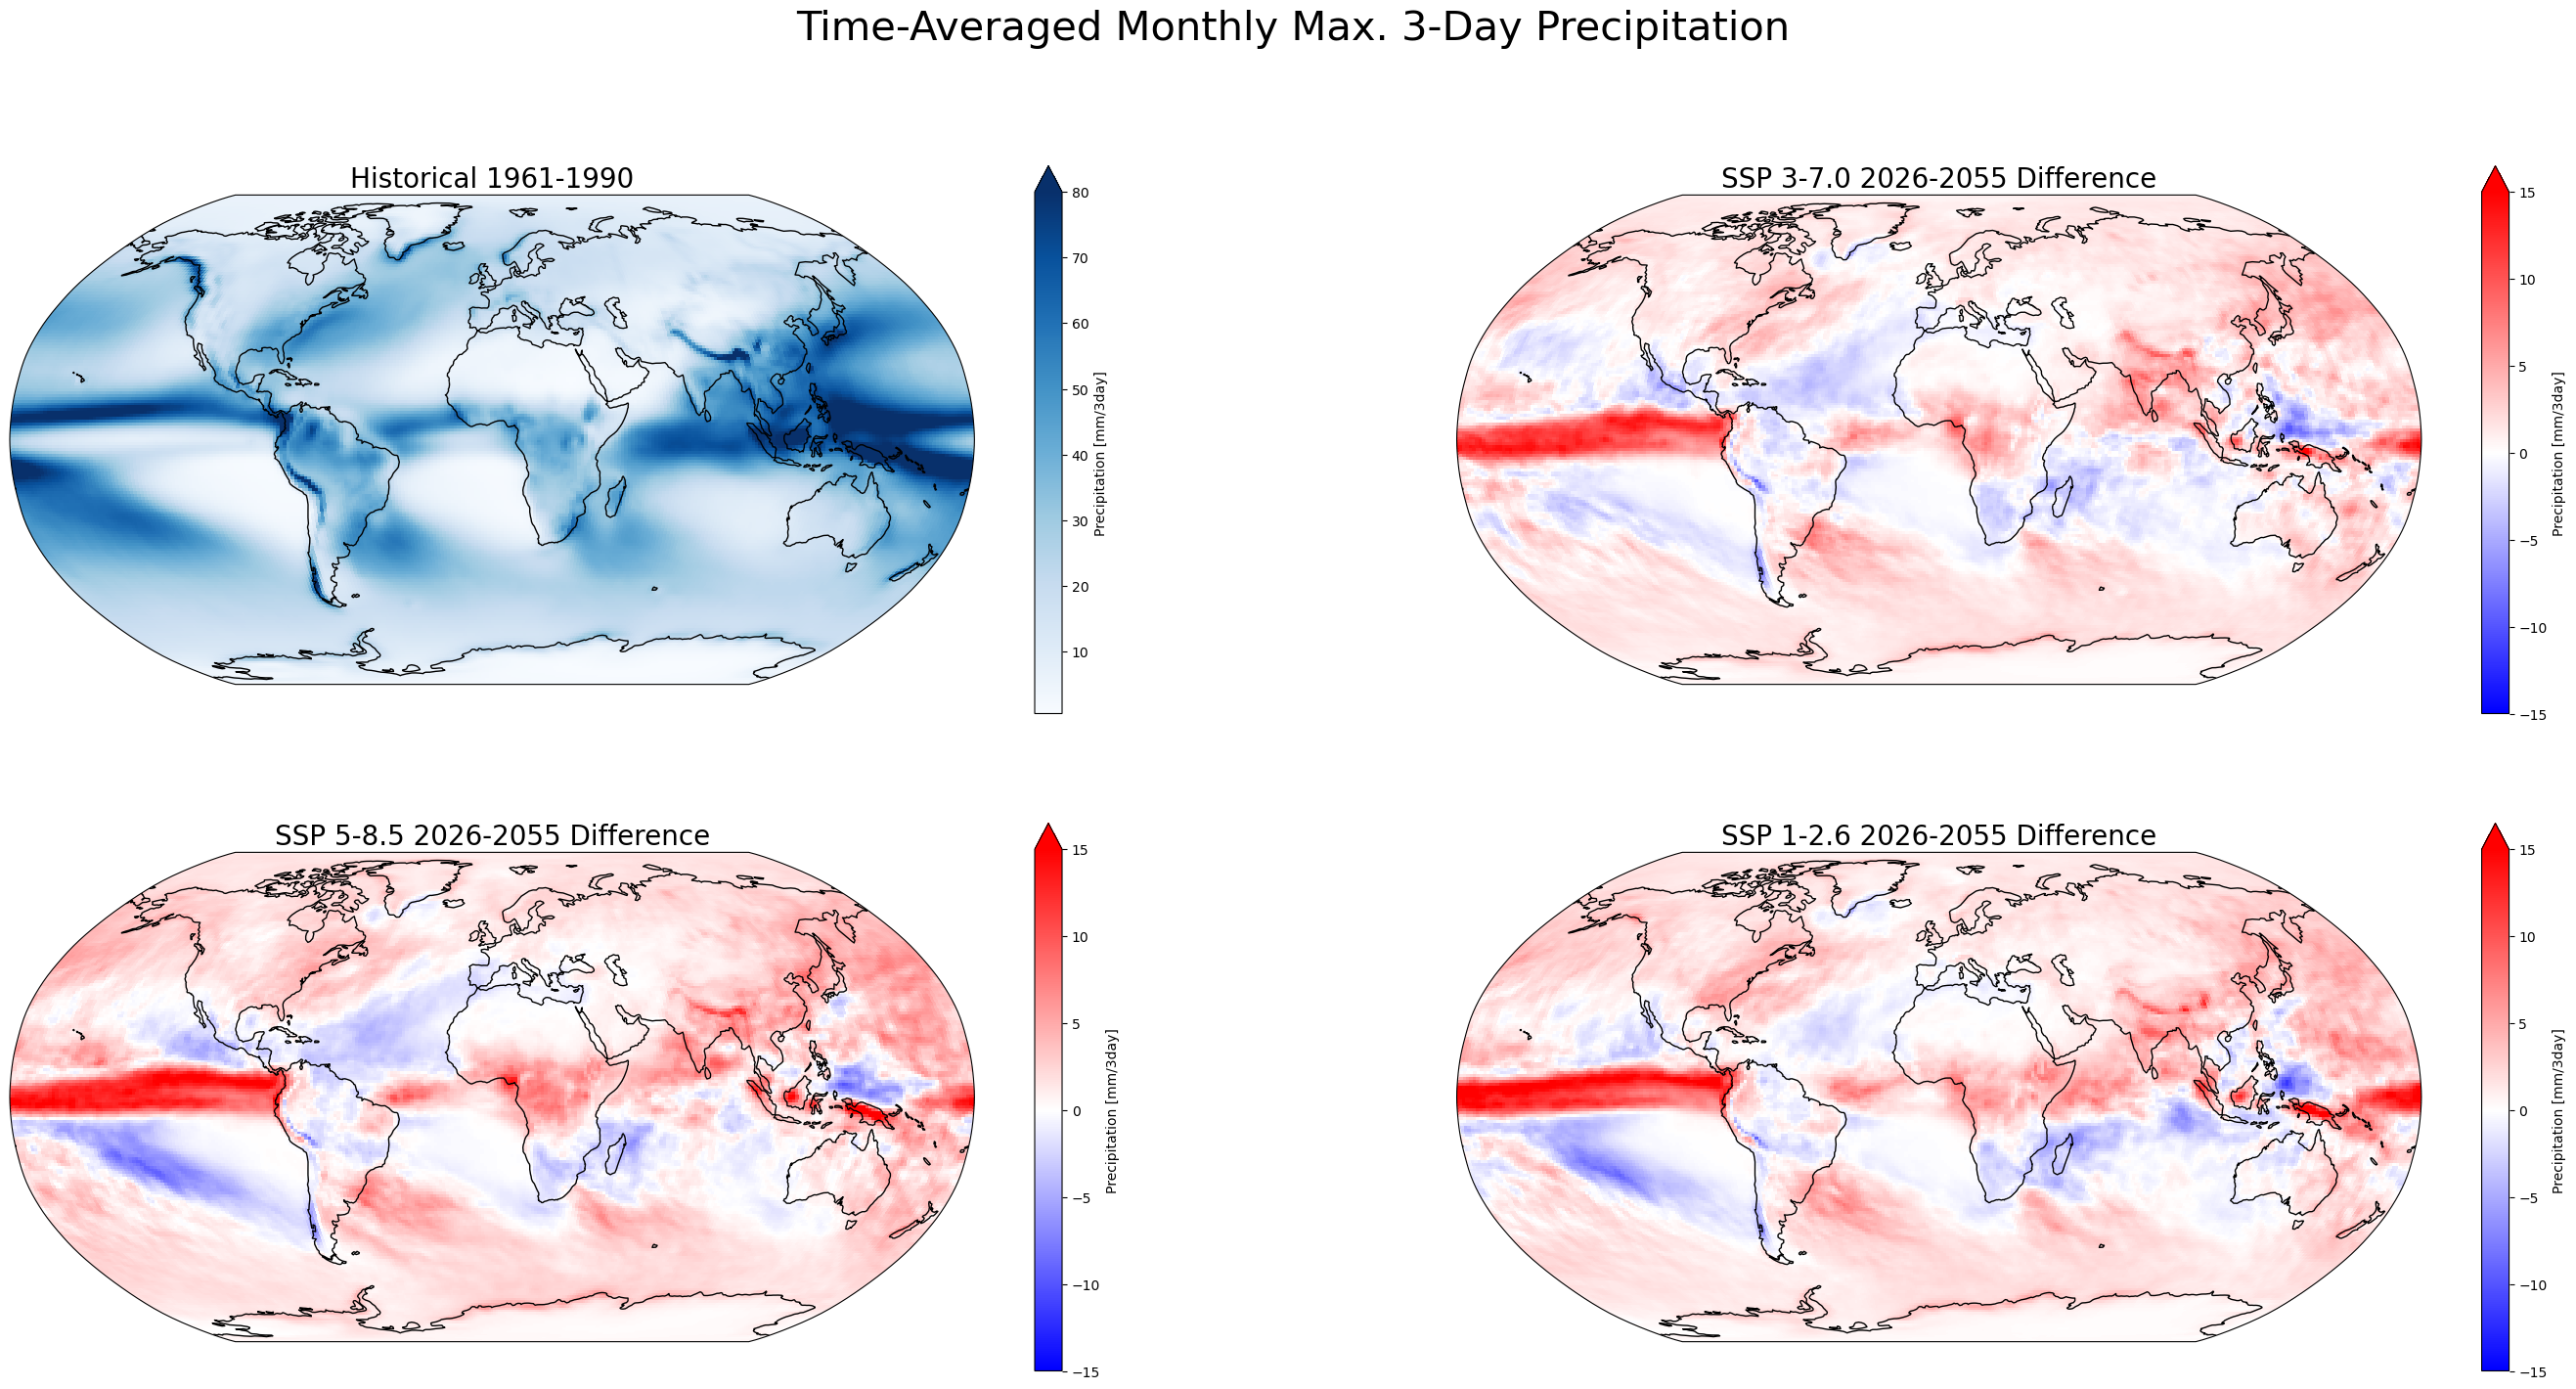

In [80]:
hist_start = cftime.DatetimeNoLeap(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True)
hist_end = cftime.DatetimeNoLeap(1990, 12, 31, 0, 0, 0, 0, has_year_zero=True)
hist_ds = cesm_hist_monthly_metrics["max_three_day"].sel(time=slice(hist_start, hist_end)).mean(dim=["member", "time"])

future_start = cftime.DatetimeNoLeap(2026, 1, 1, 0, 0, 0, 0, has_year_zero=True)
future_end = cftime.DatetimeNoLeap(2055, 12, 31, 0, 0, 0, 0, has_year_zero=True)
ssp370_ds = cesm_ssp370_monthly_metrics["max_three_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])
ssp585_ds = cesm_ssp585_monthly_metrics["max_three_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])
ssp126_ds = cesm_ssp126_monthly_metrics["max_three_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 16), facecolor='w', subplot_kw=dict(projection=ccrs.Robinson()))

hist_ds.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Blues", vmax=80)
(ssp370_ds - hist_ds).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)
(ssp585_ds - hist_ds).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)
(ssp126_ds - hist_ds).plot(ax=ax4, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)

ax1.coastlines()
ax1.set_title("Historical 1961-1990", fontsize=20)
ax2.coastlines()
ax2.set_title("SSP 3-7.0 2026-2055 Difference", fontsize=20)
ax3.coastlines()
ax3.set_title("SSP 5-8.5 2026-2055 Difference", fontsize=20)
ax4.coastlines()
ax4.set_title("SSP 1-2.6 2026-2055 Difference", fontsize=20)

f.suptitle("Time-Averaged Monthly Max. 3-Day Precipitation", fontsize=30)

Text(0.5, 0.98, 'Time-Averaged Monthly Max. 5-Day Precipitation')

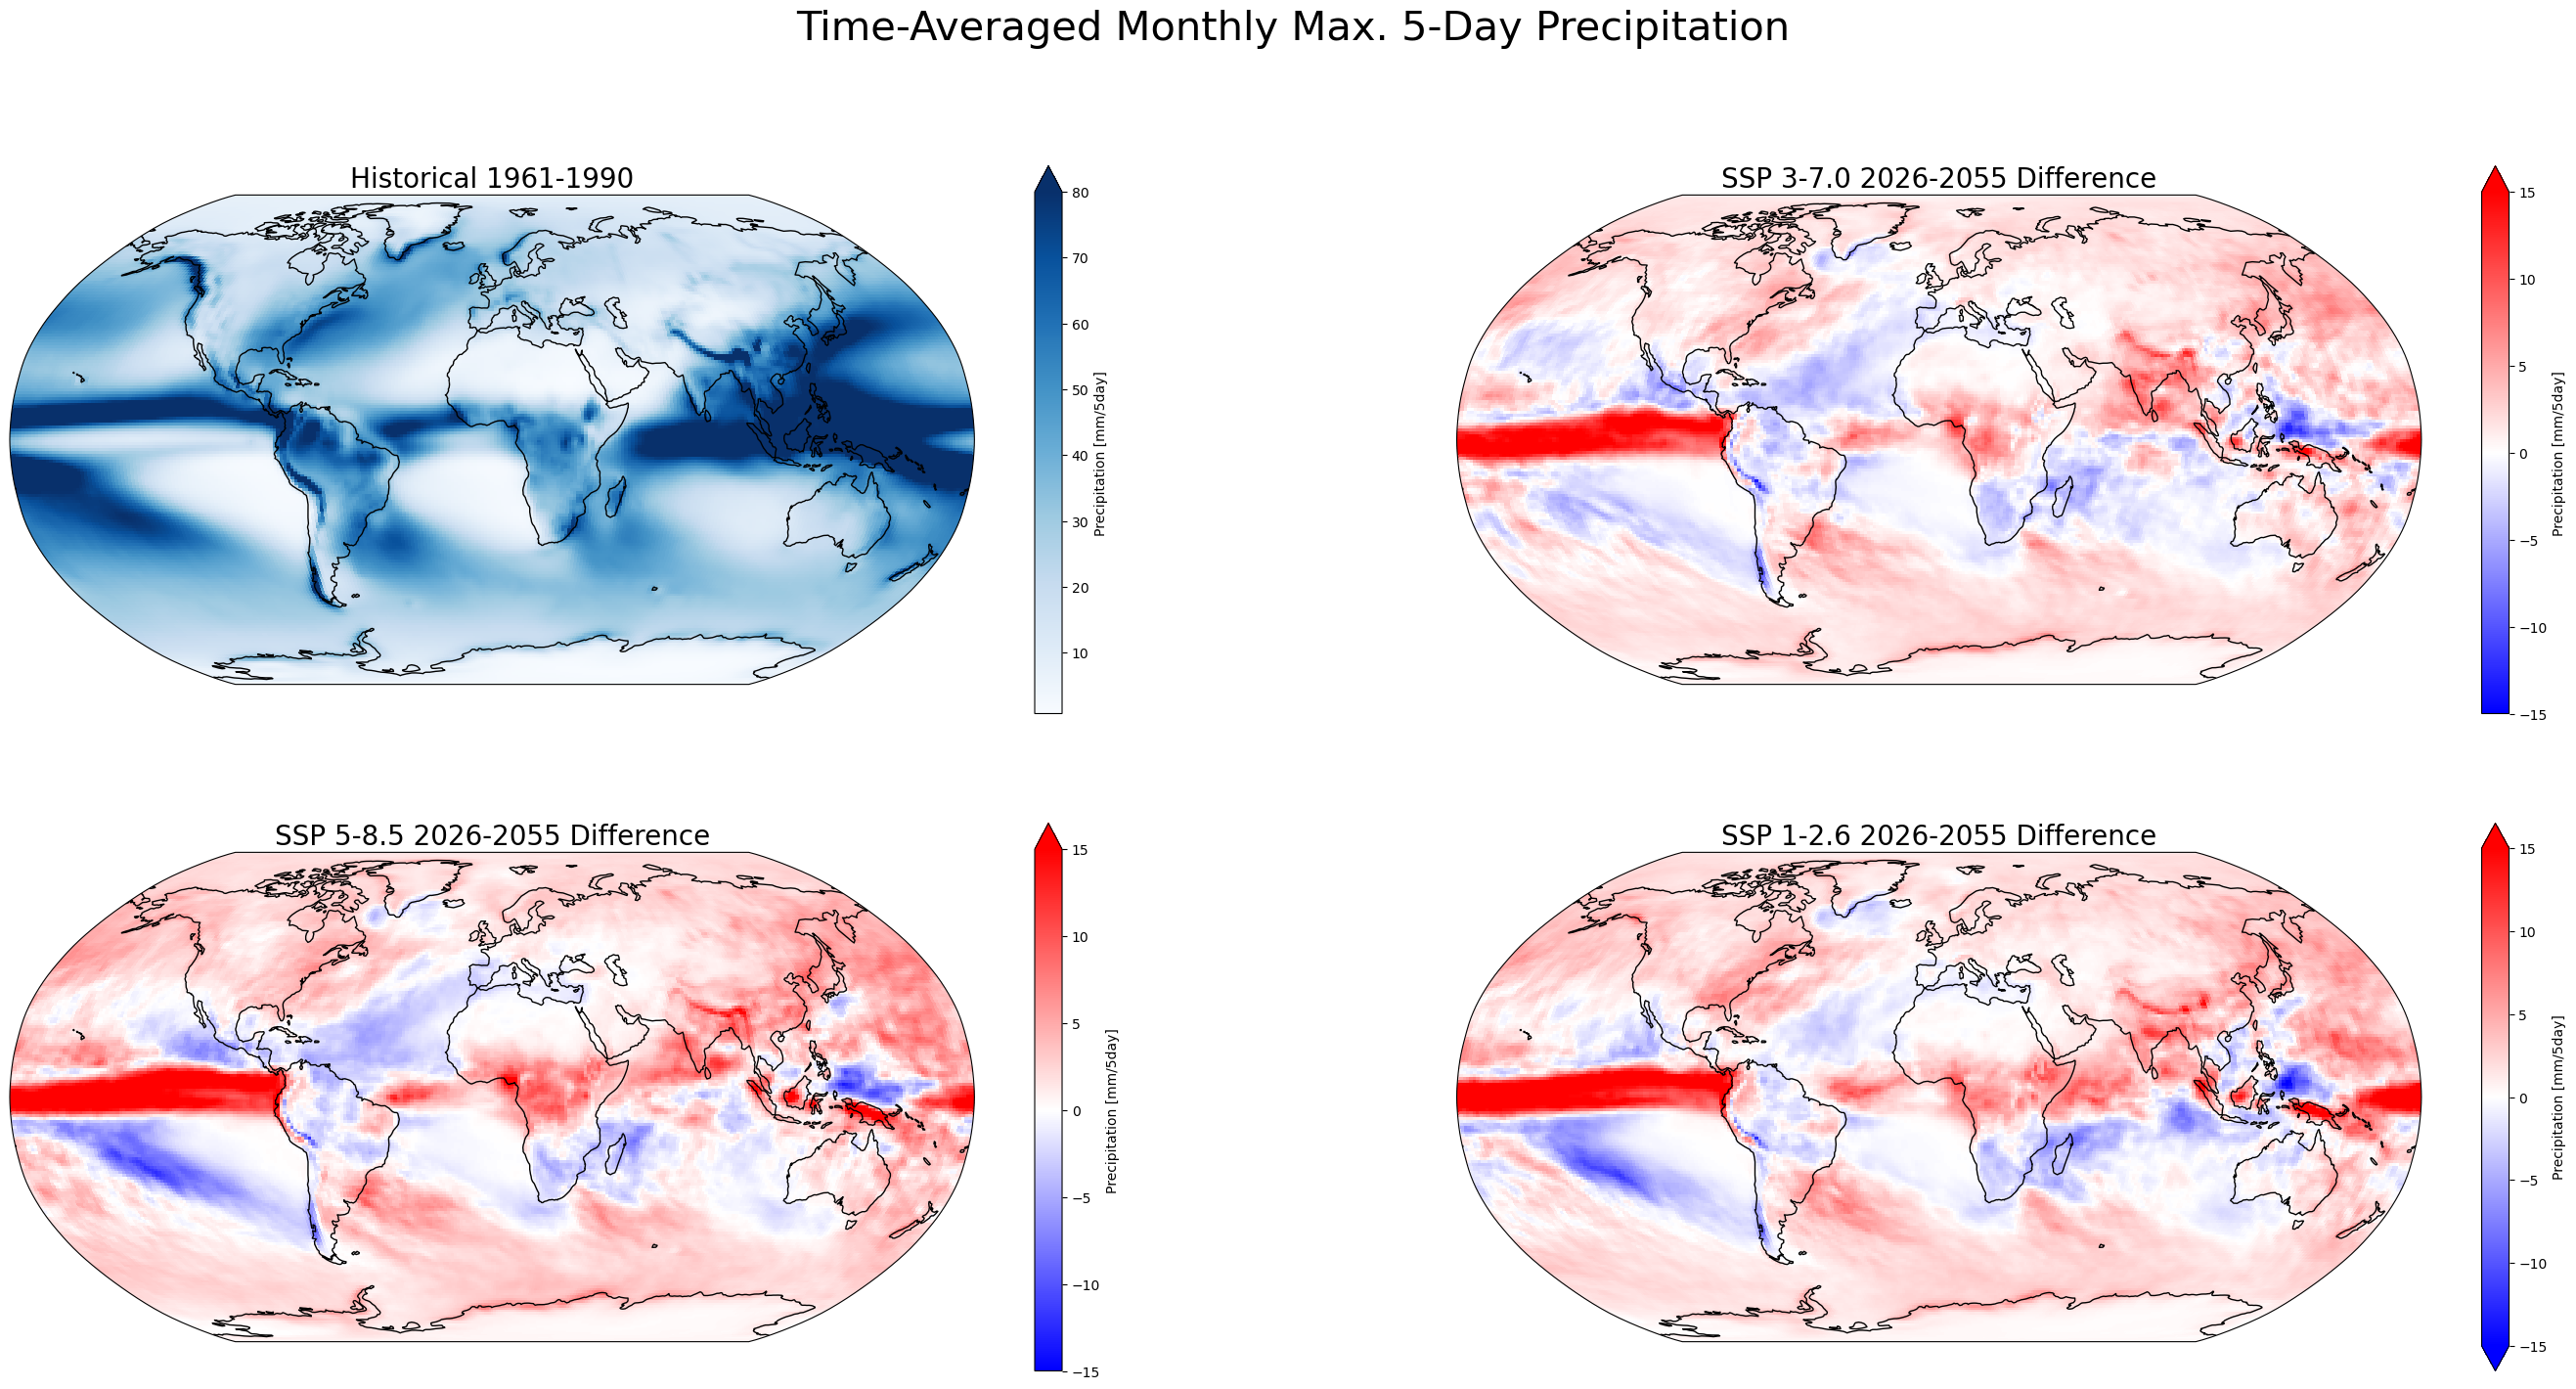

In [81]:
hist_start = cftime.DatetimeNoLeap(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True)
hist_end = cftime.DatetimeNoLeap(1990, 12, 31, 0, 0, 0, 0, has_year_zero=True)
hist_ds = cesm_hist_monthly_metrics["max_five_day"].sel(time=slice(hist_start, hist_end)).mean(dim=["member", "time"])

future_start = cftime.DatetimeNoLeap(2026, 1, 1, 0, 0, 0, 0, has_year_zero=True)
future_end = cftime.DatetimeNoLeap(2055, 12, 31, 0, 0, 0, 0, has_year_zero=True)
ssp370_ds = cesm_ssp370_monthly_metrics["max_five_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])
ssp585_ds = cesm_ssp585_monthly_metrics["max_five_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])
ssp126_ds = cesm_ssp126_monthly_metrics["max_five_day"].sel(time=slice(future_start, future_end)).mean(dim=["member", "time"])

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 16), facecolor='w', subplot_kw=dict(projection=ccrs.Robinson()))

hist_ds.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Blues", vmax=80)
(ssp370_ds - hist_ds).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)
(ssp585_ds - hist_ds).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)
(ssp126_ds - hist_ds).plot(ax=ax4, transform=ccrs.PlateCarree(), cmap="bwr", vmax=15, vmin=-15)

ax1.coastlines()
ax1.set_title("Historical 1961-1990", fontsize=20)
ax2.coastlines()
ax2.set_title("SSP 3-7.0 2026-2055 Difference", fontsize=20)
ax3.coastlines()
ax3.set_title("SSP 5-8.5 2026-2055 Difference", fontsize=20)
ax4.coastlines()
ax4.set_title("SSP 1-2.6 2026-2055 Difference", fontsize=20)

f.suptitle("Time-Averaged Monthly Max. 5-Day Precipitation", fontsize=30)